In [676]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import xarray as xr
from pprint import pprint

# from FSSLibrary import FFTBasic as fft
import skyboxdatapy as skb

## Functions

In [677]:
def set_min_plot_prop(ax):
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    # plt.yticks(range(0,150,2))
    # ax.set_xlim(xmin, xmax)
    # plt.ylim(ymin, ymax)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()


In [678]:
flumeBottom_to_MPLBottom = 3 #mm
pp_zero = {
    'Mo01': 300 + flumeBottom_to_MPLBottom,
    'Mo02': 400 + flumeBottom_to_MPLBottom,
    'Mo03': 600 + flumeBottom_to_MPLBottom,
    'Mo04': 650 + flumeBottom_to_MPLBottom,
    'Mo05': 700 + flumeBottom_to_MPLBottom,
    'Mo06': 750 + flumeBottom_to_MPLBottom,
    'Mo07': 800 + flumeBottom_to_MPLBottom,
    'Mo08': 850 + flumeBottom_to_MPLBottom,
}

## Define the cases

In [679]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/data_nosync"
testName1 = "Test171"

file1 = skb.io.find_unique_file(data_folder, testName1, ext="mat")
print(f"Processing file: {file1}")
loaded_mat1 = skb.io.load_case(file1)

skb.utils.print_test_properties(loaded_mat1)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d0918/Measure_MAT/Test171_E_d60_FC72_H127_FCL0960_R00.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'ConversionOffset', 'DefaultData', 'MP3Filtered', 'MP3RawValue', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test171
   - testType: E
   - repeatType: N
   - useTest: nan
   - fSampling: 50.0
   - calibrationFile: Test171
   - depthAtWM: 0.601
   - depthAtMPL: 0.568
   - waveType: FC72
   - waveAmplitude: 0.127
   - wavePeriod: nan
   - focusingLocation: 9.6
   - remarks: Shagun
=== End of Test Properties ===



In [680]:
testName2 = "Test339"

file2 = skb.io.find_unique_file(data_folder, testName2, ext="mat")
print(f"Processing file: {file2}")
loaded_mat2 = skb.io.load_case(file2)

skb.utils.print_test_properties(loaded_mat2)

Processing file: /home/shagun/Acads/SkyBox/ExpData/data_nosync/d1008/Measure_MAT/Test339_M_d60_FC72_H127_FCL0960_R02.mat

=== Reading MAT ===
Top-level keys: ['ConversionFactor', 'DefaultData', 'MP3Filtered', 'TestProperties']
=== Successfully loaded using hdf5storage ===


=== Test Properties ===
   - testName: Test339
   - testType: MPL
   - repeatType: R2
   - useTest: nan
   - fSampling: 2048.0
   - calibrationFile: Test_d1024_Calib
   - depthAtWM: 0.604
   - depthAtMPL: 0.571
   - waveType: FC72
   - waveAmplitude: 0.127
   - wavePeriod:  
   - focusingLocation: 9.6
   - remarks: Empty = Test171, GP1, GP2, GP3
=== End of Test Properties ===



In [681]:
testName_peaks = 'Test339'

## Extract Default Dataset and Set Tare

In [682]:
ds1 = loaded_mat1["DefaultData"]
testProp1 = loaded_mat1["TestProperties"]
fSampling1 = testProp1['fSampling']
print(ds1.attrs)

ds2 = loaded_mat2["DefaultData"]
testProp2 = loaded_mat2["TestProperties"]
fSampling2 = testProp2['fSampling']
print(ds2.attrs)

# Sometimes need to skip initial data.
# Skip first 10 indexes
ds1 = ds1.isel(Time=slice(10, None))
ds2 = ds2.isel(Time=slice(10, None))

# Set Tare for all probes
tare_tmin = 0
tare_tmax = 2
ds1 = skb.postprocess.set_all_probe_tare(ds1, start_time=tare_tmin, end_time=tare_tmax)
ds2 = skb.postprocess.set_all_probe_tare(ds2, start_time=tare_tmin, end_time=tare_tmax)

# Can also do a slice of time if needed here

pass

{'reference': 'MP3RawValue'}
{'reference': 'MP3Filtered'}


## Shift time coord to overlap signals

### Based on max-value

In [683]:
def get_timeidx_of_max(ds1, ds2, tmin, tmax):
    """Get time index of max value in both datasets in the given time range."""
    ds1_cut = ds1.sel(Time=slice(tmin, tmax))
    ds2_cut = ds2.sel(Time=slice(tmin, tmax))

    ds1_max_idxtime = ds1_cut.idxmax('Time')
    ds2_max_idxtime = ds2_cut.idxmax('Time')

    return ds1_max_idxtime, ds2_max_idxtime

### Based on cross-correlation

In [684]:
def sync_signals_crosscorr(ds1, fSampling1, ds2, fSampling2, tmin, tmax, wg='WG01'):
    """Sync the signals using cross-correlation for the given wave gauge."""
    
    ds1_cut = ds1[wg].sel(Time=slice(tmin, tmax))
    ds2_cut = ds2[wg].sel(Time=slice(tmin, tmax))

    # time_lag = skb.postprocess.sync_signals_crosscorr_downsample(
    time_lag_maxCorr, time_lag_mat = skb.postprocess.sync_signals_crosscorr_upsample(
        ds1_cut, fSampling1, 
        ds2_cut, fSampling2, plotflag=True
    )

    return time_lag_maxCorr, time_lag_mat

Peaks in cross-corr: [32.65087891]


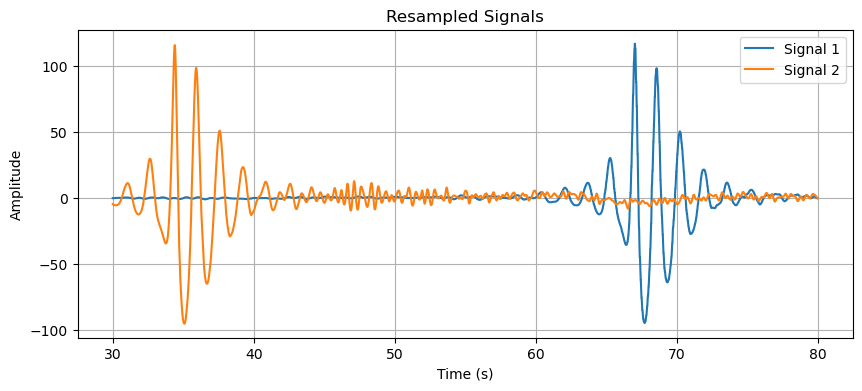

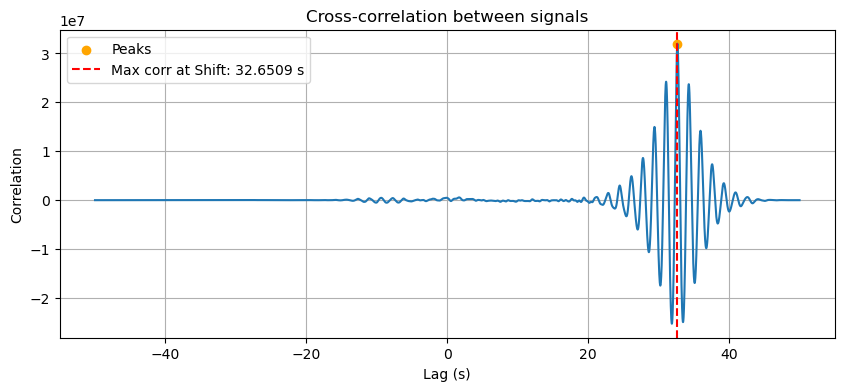

Shifting ds2 by 32.65087890625


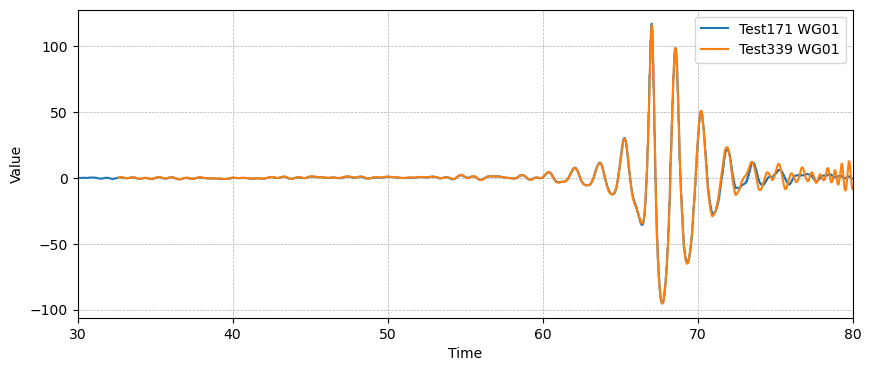

In [685]:
# # Shift ds2 time to align max of WG01
# # Can change to any other probe as needed

# # Using max-value
# ds1_max_idxtime, ds2_max_idxtime = get_timeidx_of_max(ds1, ds2, tmin=0, tmax=22)
# tShift = ds1_max_idxtime['WG01'].values - ds2_max_idxtime['WG01'].values

# Using cross-correlation
tShift_maxCorr, tShift_array = sync_signals_crosscorr(
    ds1, fSampling1, ds2, fSampling2, 
    tmin=30, tmax=80, wg = 'WG01' )
tShift = tShift_maxCorr
# tShift = tShift_array[2]

ds2 = ds2.assign_coords(Time=ds2['Time'] + tShift)
ds2.attrs['TimeShiftApplied'] = tShift
print(f"Shifting ds2 by {ds2.attrs['TimeShiftApplied']}")

# Post shifting comparison plots
tmin = 30
tmax = 80

fig, ax = plt.subplots(figsize=(10,4))
ds1['WG01'].plot(linestyle='-', label=f"{testName1} WG01")
ds2['WG01'].plot(linestyle='-', label=f"{testName2} WG01")
ax.set_xlim(tmin, tmax)
set_min_plot_prop(ax)
plt.show()


## Get LED on off indices

In [686]:
skb.postprocess.update_LED_transition_indices(ds1)
skb.postprocess.update_LED_transition_indices(ds2)

print("DS1 LED Transition Indices:")
print(f'LED_time_0_to_1 = {ds1.attrs["LED_time_0_to_1"]:.4f}')
print(f'LED_time_1_to_0 = {ds1.attrs["LED_time_1_to_0"]:.4f}')
print(f'dt = {ds1.attrs["LED_time_1_to_0"] - ds1.attrs["LED_time_0_to_1"]:.4f}')

print("\nDS2 LED Transition Indices:")
print(f'LED_time_0_to_1 = {ds2.attrs["LED_time_0_to_1"]:.4f}')
print(f'LED_time_1_to_0 = {ds2.attrs["LED_time_1_to_0"]:.4f}')
print(f'dt = {ds2.attrs["LED_time_1_to_0"] - ds2.attrs["LED_time_0_to_1"]:.4f}')

No LED transitions found in 'LED-chan100' data.
DS1 LED Transition Indices:
LED_time_0_to_1 = 0.0000
LED_time_1_to_0 = 0.0000
dt = 0.0000

DS2 LED Transition Indices:
LED_time_0_to_1 = 40.8057
LED_time_1_to_0 = 47.0562
dt = 6.2505


## Load peaks

In [687]:
data_folder = "/home/shagun/Acads/SkyBox/ExpData/AllTest_log"
peaks_file_name = "log_videos_peak_focusing.xlsx"

peaks_file = pd.ExcelFile(f"{data_folder}/{peaks_file_name}")
df = pd.read_excel(peaks_file, sheet_name='Sheet1')

# pprint(df.head())

In [688]:
testpeaks = df[df['Test_ID'] == testName_peaks]
# print(testpeaks)

testpeaks_LED_on = testpeaks[testpeaks['event_type']=='LED_on']['time_s']
pprint(testpeaks_LED_on); print()

tShift_peaks = ds2.attrs["LED_time_0_to_1"] - testpeaks_LED_on.values[0]
pprint(f"Shifting video peaks by {tShift_peaks}"); print()

depthAtMPL = testProp2['depthAtMPL'] 

pprint(testpeaks.head()); print()
testpeaks.loc[:,'time_s'] = testpeaks['time_s'] + tShift_peaks

pprint(testpeaks.head()); print()

testpeaks_LED_on = testpeaks[testpeaks['event_type']=='LED_on']['time_s']
testpeaks_LED_off = testpeaks[testpeaks['event_type']=='LED_off']['time_s']
testpeaks_peaks = testpeaks[testpeaks['event_type'] == 'peak']
testpeaks_peaks.loc[:, 'value'] = testpeaks_peaks['value'] - depthAtMPL*1000 + flumeBottom_to_MPLBottom


pprint(testpeaks_peaks.head())

52    8.141
Name: time_s, dtype: float64

'Shifting video peaks by 32.66466890625'

    Test_ID event_type  event_id  time_s  value
52  Test339     LED_on         1   8.141    1.0
53  Test339    LED_off         1  14.398    0.0
54  Test339       peak         1  37.537  870.0
55  Test339      break         0   0.000    0.0

    Test_ID event_type  event_id     time_s  value
52  Test339     LED_on         1  40.805669    1.0
53  Test339    LED_off         1  47.062669    0.0
54  Test339       peak         1  70.201669  870.0
55  Test339      break         0  32.664669    0.0

    Test_ID event_type  event_id     time_s  value
54  Test339       peak         1  70.201669  302.0


## Plot signals

### WM Probe

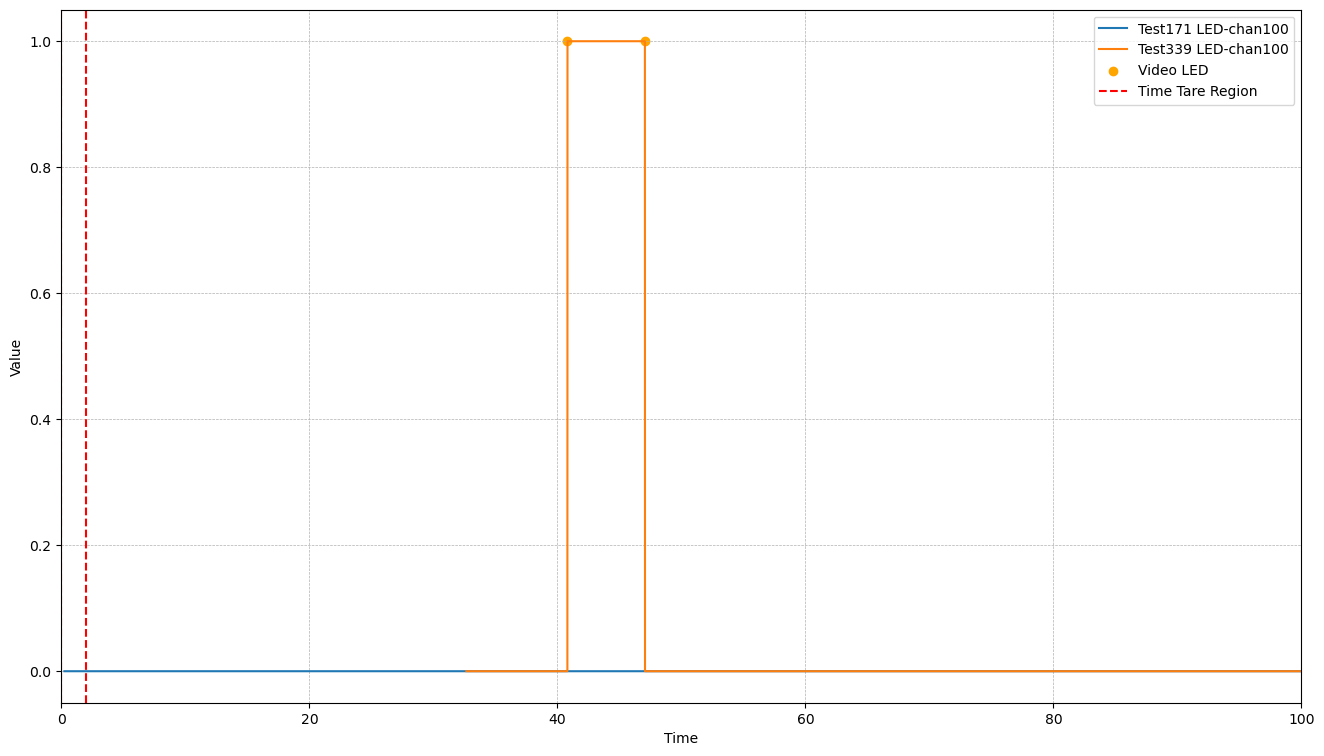

In [689]:
xmin = 0
xmax = 100


# fig, ax = plt.subplots(figsize=(16,9))
# ds1['WM'].plot(linestyle='-', label=f"{testName1} WM")
# ds2['WM'].plot(linestyle='-', label=f"{testName2} WM")
# ax.axvline(x=tare_tmin, color='r', linestyle='--')
# ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['LED-chan100'].plot(linestyle='-', label=f"{testName1} LED-chan100")
ds2['LED-chan100'].plot(linestyle='-', label=f"{testName2} LED-chan100")
plt.scatter([testpeaks_LED_on.values, testpeaks_LED_off.values], [1, 1], 
    color = 'orange',label = 'Video LED')
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

### WG01 - WG03

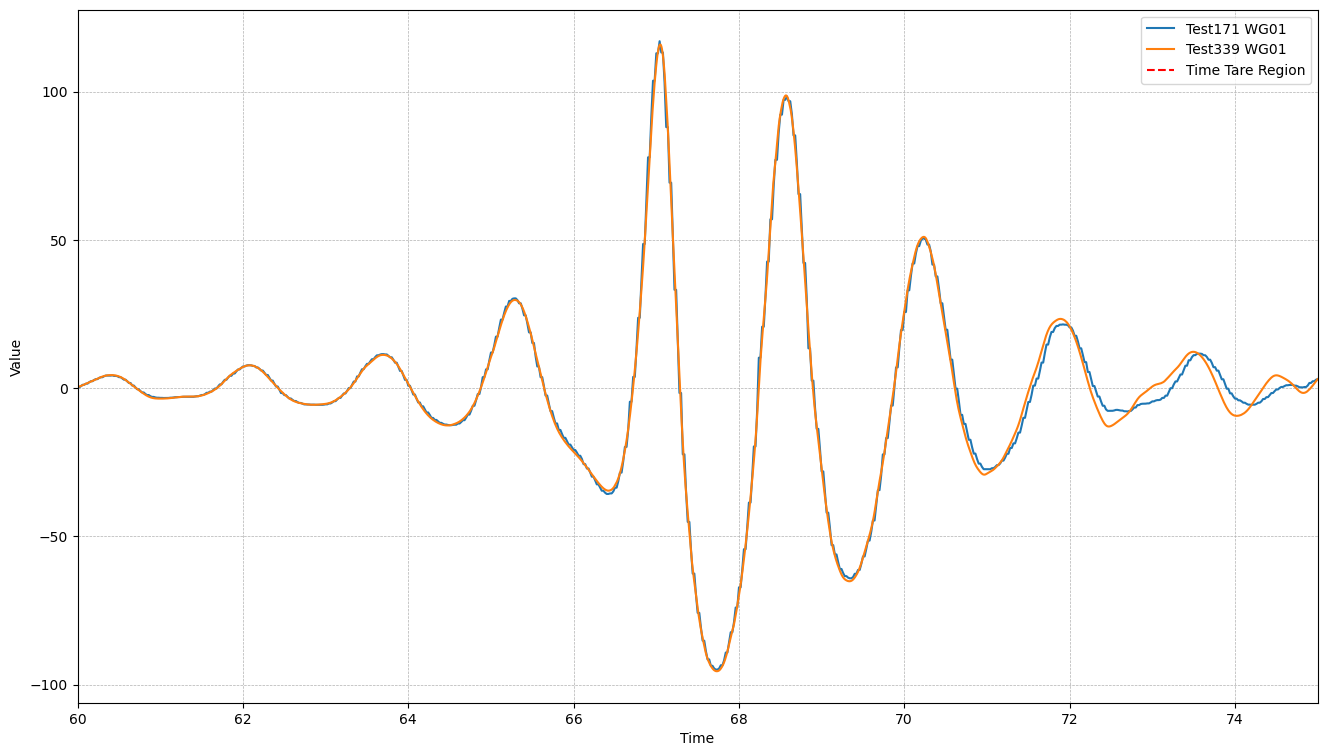

In [690]:
xmin = 60
xmax = 75

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG01'].plot(linestyle='-', label=f"{testName1} WG01")
ds2['WG01'].plot(linestyle='-', label=f"{testName2} WG01")
ax.axvline(x=tare_tmin, color='r', linestyle='--')
ax.axvline(x=tare_tmax, color='r', linestyle='--', label='Time Tare Region')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

# fig, ax = plt.subplots(figsize=(16,9))
# ds1['WG02'].plot(linestyle='-', label=f"{testName1} WG02")
# ds2['WG02'].plot(linestyle='-', label=f"{testName2} WG02")
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

# fig, ax = plt.subplots(figsize=(16,9))
# ds1['WG03'].plot(linestyle='-', label=f"{testName1} WG03")
# ds2['WG03'].plot(linestyle='-', label=f"{testName2} WG03")
# # plt.yticks(range(0,150,2))
# ax.set_xlim(xmin, xmax)
# # plt.ylim(ymin, ymax)
# set_min_plot_prop(ax)
# plt.show()

pass

### WG04 - WG06

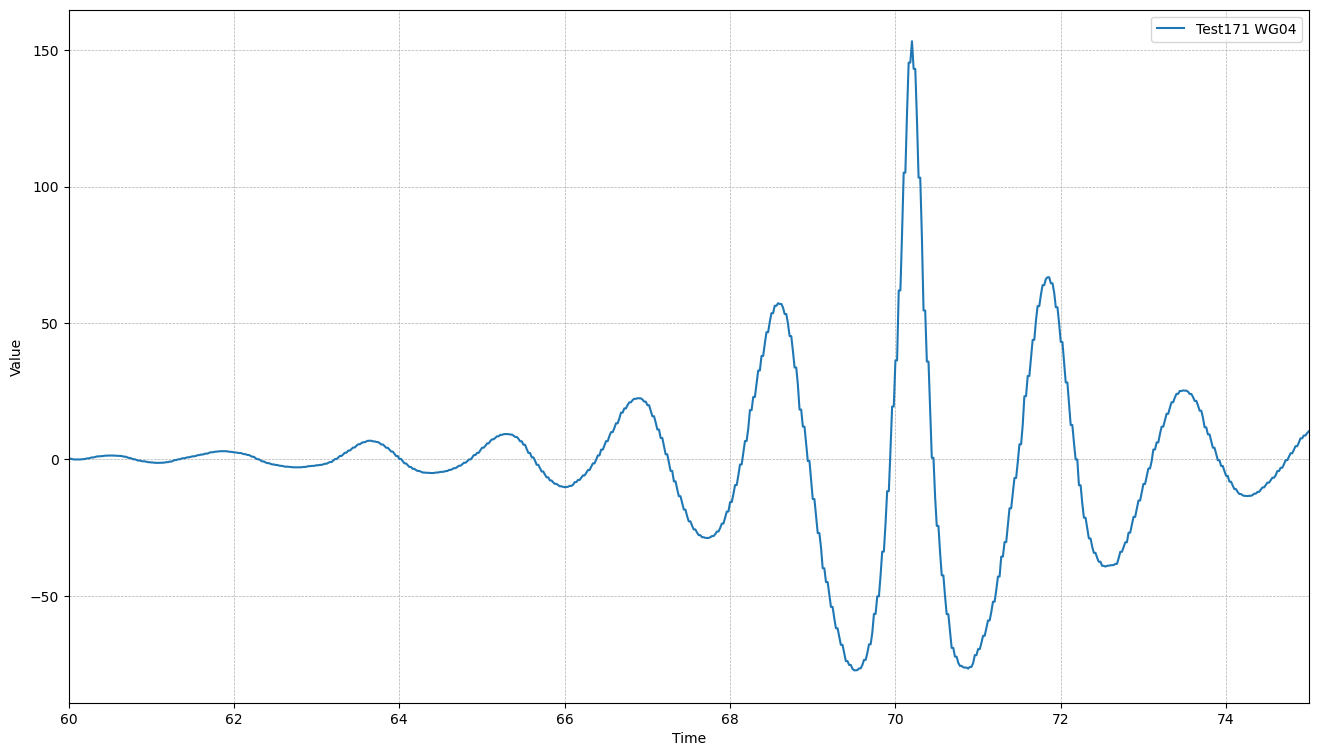

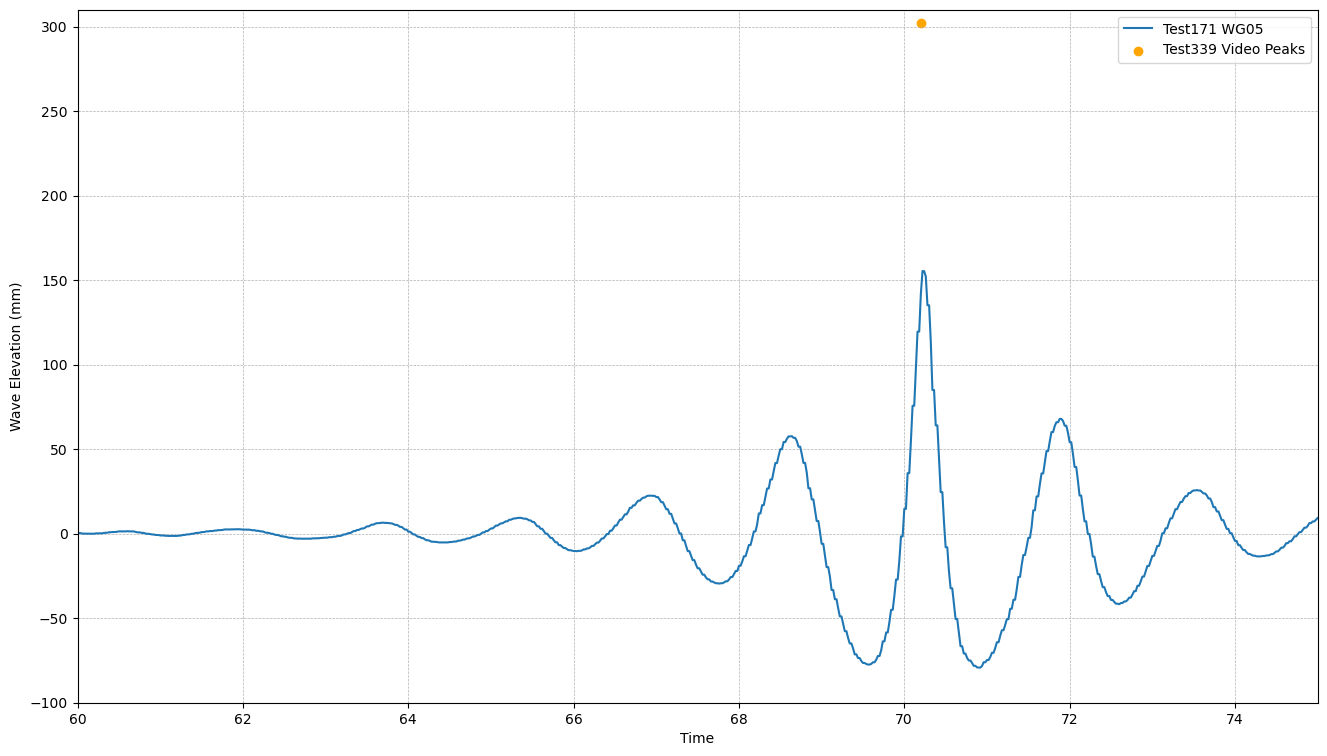

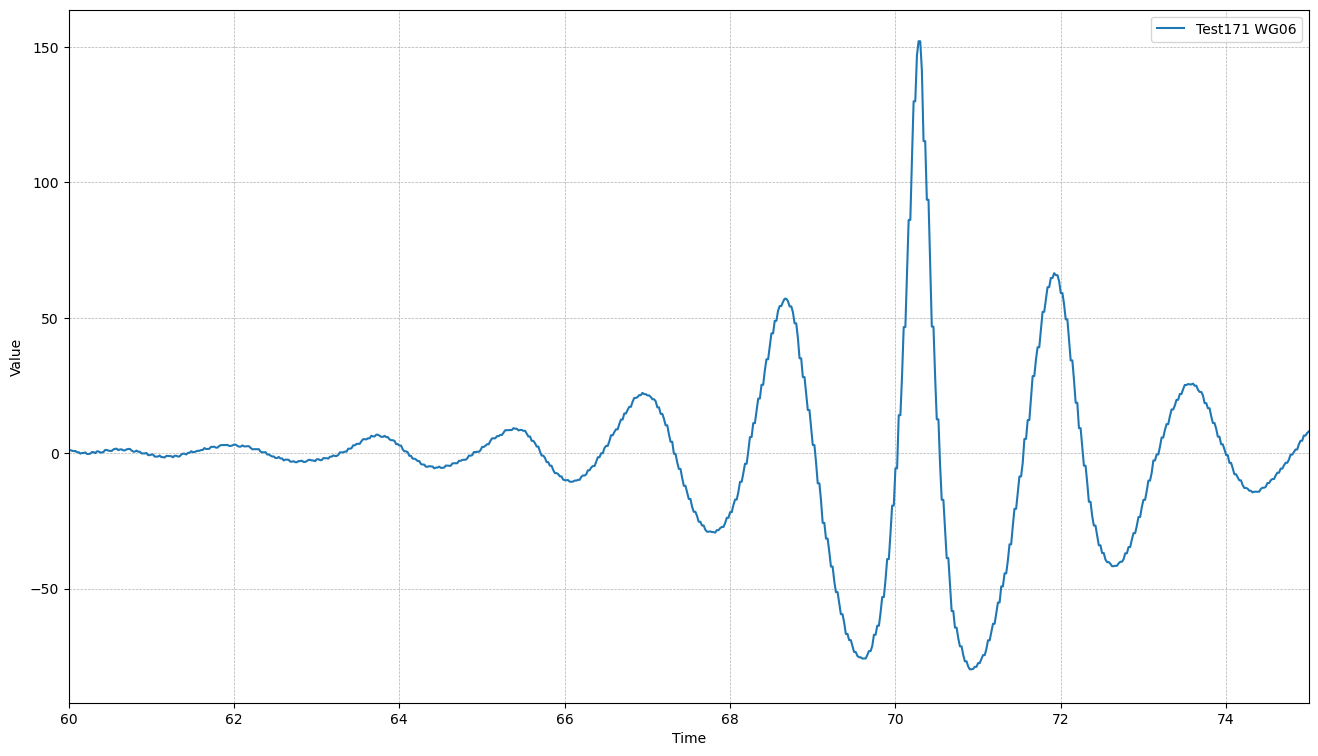

In [691]:
fig, ax = plt.subplots(figsize=(16,9))
ds1['WG04'].plot(linestyle='-', label=f"{testName1} WG04")
# ds2['WG04'].plot(linestyle='-', label=f"{testName2} WG04")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG05'].plot(linestyle='-', label=f"{testName1} WG05")
# ds2['WG05'].plot(linestyle='-', label=f"{testName2} WG05")
plt.scatter(testpeaks_peaks['time_s'], testpeaks_peaks['value'], 
    color = 'orange', label = f'{testName_peaks} Video Peaks')
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
plt.ylim(-100, 310)
set_min_plot_prop(ax)
ax.set_ylabel("Wave Elevation (mm)")
plt.show()

# fig, ax = plt.subplots(figsize=(16,9))
# plt.scatter(testpeaks_peaks['time_s'], testpeaks_peaks['value'], color = 'orange')
# ax.set_xlim(xmin, xmax)
# plt.show()

fig, ax = plt.subplots(figsize=(16,9))
ds1['WG06'].plot(linestyle='-', label=f"{testName1} WG06")
# ds2['WG06'].plot(linestyle='-', label=f"{testName2} WG06")
# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.show()

pass

### Mo01 - Mo02

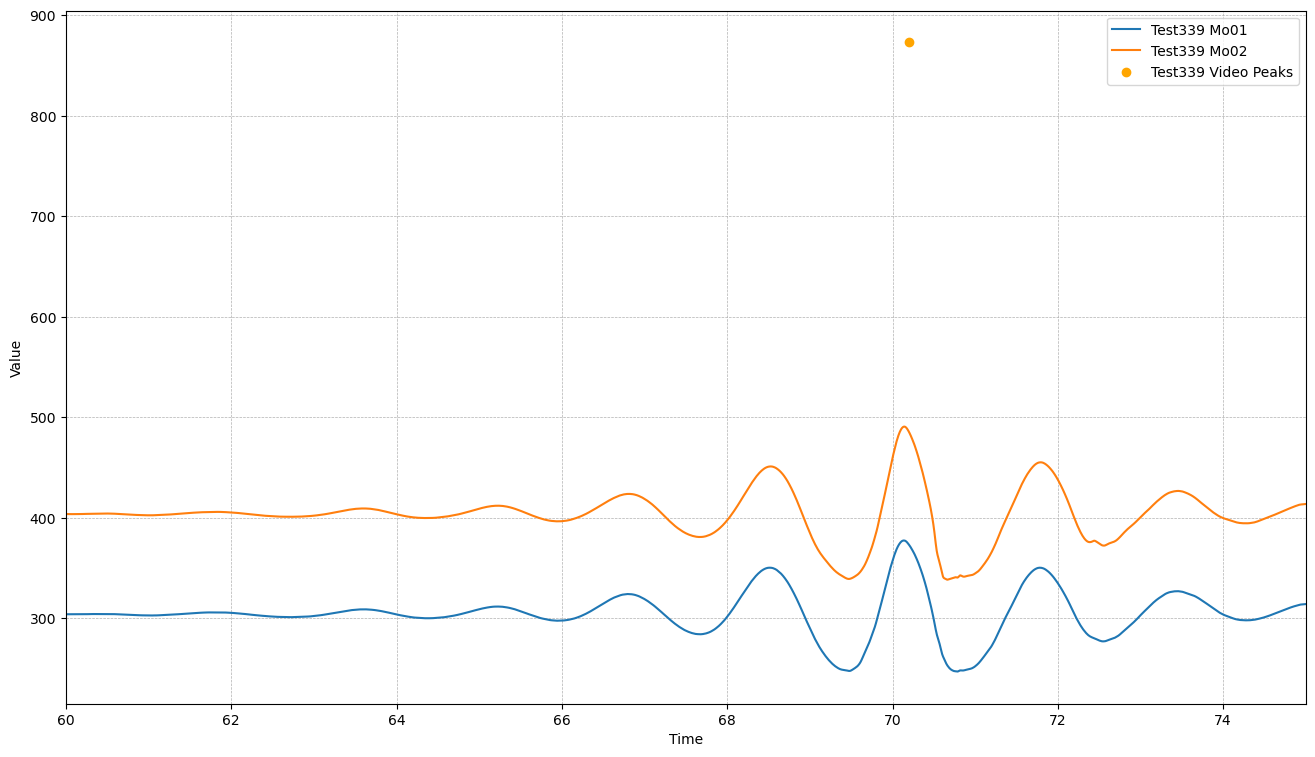

In [692]:
fig, ax = plt.subplots(figsize=(16,9))
probeid = 'Mo01'
plt.plot(ds2[probeid].Time, ds2[probeid].values + pp_zero[probeid], linestyle='-', label=f"{testName2} {probeid}")
probeid = 'Mo02'
plt.plot(ds2[probeid].Time, ds2[probeid].values + pp_zero[probeid], linestyle='-', label=f"{testName2} {probeid}")

plt.scatter(testpeaks_peaks['time_s'], 
    testpeaks_peaks['value']+testProp2['depthAtMPL']*1e3, 
    color = 'orange', label = f'{testName_peaks} Video Peaks')

# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# ax.set_xlim(36, 40)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.legend(loc='upper right')
plt.show()

### Mo03 - Mo05

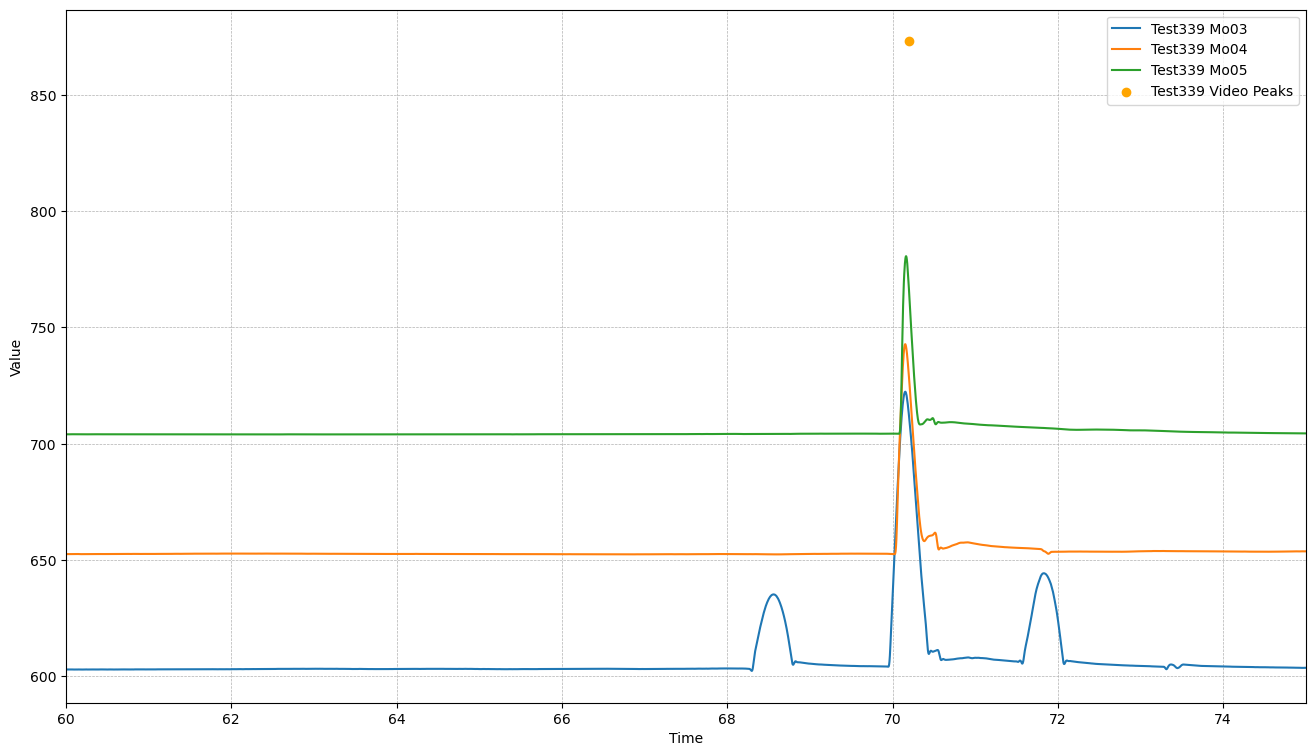

In [693]:
fig, ax = plt.subplots(figsize=(16,9))
probeid = 'Mo03'
plt.plot(ds2[probeid].Time, ds2[probeid].values + pp_zero[probeid], linestyle='-', label=f"{testName2} {probeid}")
probeid = 'Mo04'
plt.plot(ds2[probeid].Time, ds2[probeid].values + pp_zero[probeid], linestyle='-', label=f"{testName2} {probeid}")
probeid = 'Mo05'
plt.plot(ds2[probeid].Time, ds2[probeid].values + pp_zero[probeid], linestyle='-', label=f"{testName2} {probeid}")

plt.scatter(testpeaks_peaks['time_s'], 
    testpeaks_peaks['value']+testProp2['depthAtMPL']*1e3, 
    color = 'orange', label = f'{testName_peaks} Video Peaks')

# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# ax.set_xlim(36, 40)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.legend(loc='upper right')
plt.show()

### Mo06 - Mo08

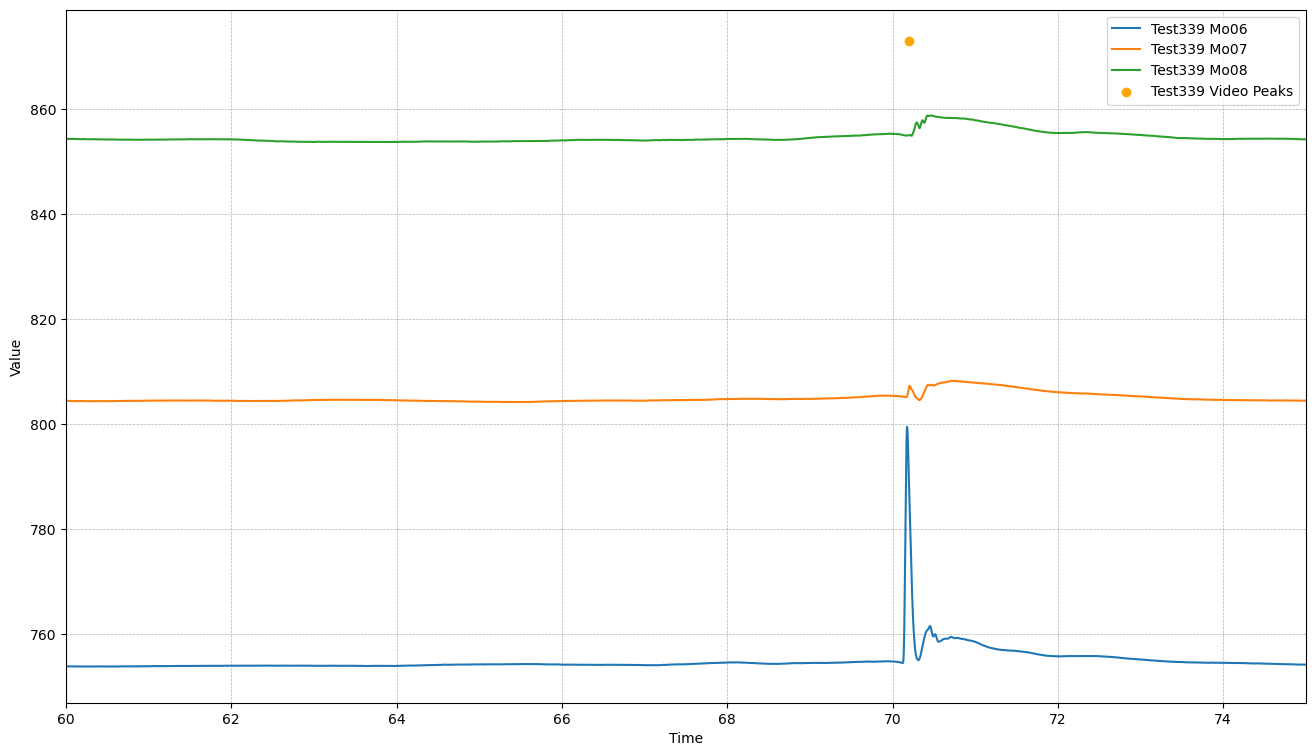

In [694]:
fig, ax = plt.subplots(figsize=(16,9))

probeid = 'Mo06'
plt.plot(ds2[probeid].Time, ds2[probeid].values + pp_zero[probeid], linestyle='-', label=f"{testName2} {probeid}")
probeid = 'Mo07'
plt.plot(ds2[probeid].Time, ds2[probeid].values + pp_zero[probeid], linestyle='-', label=f"{testName2} {probeid}")
probeid = 'Mo08'
plt.plot(ds2[probeid].Time, ds2[probeid].values + pp_zero[probeid], linestyle='-', label=f"{testName2} {probeid}")

plt.scatter(testpeaks_peaks['time_s'], 
    testpeaks_peaks['value']+testProp2['depthAtMPL']*1e3, 
    color = 'orange', label = f'{testName_peaks} Video Peaks')

# plt.yticks(range(0,150,2))
ax.set_xlim(xmin, xmax)
# ax.set_xlim(36, 40)
# plt.ylim(ymin, ymax)
set_min_plot_prop(ax)
plt.legend(loc='upper right')
plt.show()

## Find maxima

In [695]:
def print_min_max_all_signals(ds, probes=None):
    ds_min = ds.min('Time')
    ds_min_idxtime = ds.idxmin('Time')
    ds_max = ds.max('Time')
    ds_max_idxtime = ds.idxmax('Time')

    if probes is not None:
        vars_to_check = probes
    else:
        vars_to_check = ds.data_vars

    for var in vars_to_check:
        print(f"Signal: {var}", end=" ")        
        print(f"  Max Value: {ds_max[var].values} at : {ds_max_idxtime[var].values: .4f}", end=" ")
        print(f"  Min Value: {ds_min[var].values} at : {ds_min_idxtime[var].values: .4f}")
    

In [696]:
tmin = xmin
tmax = xmax

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

print("DS1 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds1_cut)
print()

print("DS2 Signal Min/Max in selected time range:")
print_min_max_all_signals(ds2_cut)  

DS1 Signal Min/Max in selected time range:
Signal: WG01   Max Value: 117.0172596590909 at :  67.0414   Min Value: -94.9169403409091 at :  67.7214
Signal: WG02   Max Value: 113.45544636363637 at :  67.2014   Min Value: -101.46595363636364 at :  67.8414
Signal: WG03   Max Value: 99.57053988636363 at :  68.8814   Min Value: -103.09046011363637 at :  68.1014
Signal: WG04   Max Value: 153.32574079545455 at :  70.2014   Min Value: -77.31295920454545 at :  69.5014
Signal: WG05   Max Value: 155.3509980681818 at :  70.2214   Min Value: -79.20760193181819 at :  70.9014
Signal: WG06   Max Value: 152.10887045454544 at :  70.2814   Min Value: -79.80472954545455 at :  70.9014
Signal: WG07   Max Value: 105.1871559090909 at :  71.6014   Min Value: -102.4653440909091 at :  72.3814
Signal: WG08   Max Value: 112.67892329545455 at :  73.2814   Min Value: -102.59107670454544 at :  72.5614
Signal: WG09   Max Value: 113.89960238636363 at :  73.4414   Min Value: -98.34989761363637 at :  72.7614
Signal: LED-ch

## Plot Spec

In [697]:
def getSpec(wg, fs, ax, xlim, lbl, fRef=1):    
    fHalf, fAmp, fS = skb.spec.get_single_sided_spectrum(wg, fs)

    
    ax.plot(fHalf/fRef, fAmp, label=lbl)
    ax.set_xlabel("Frequency f/fRef")
    ax.set_ylabel("Amplitude (mm)")
    ax.set_title("Single-Sided FFT")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.set_xlim(xlim)
    # plt.show()

    return fHalf, fAmp, fS

Sample Len = 750
Least count Hz = 0.06666666666666667
Max Freq (Half band) Hz = 25.0
Sample Len = 30720
Least count Hz = 0.06666666666666667
Max Freq (Half band) Hz = 1024.0


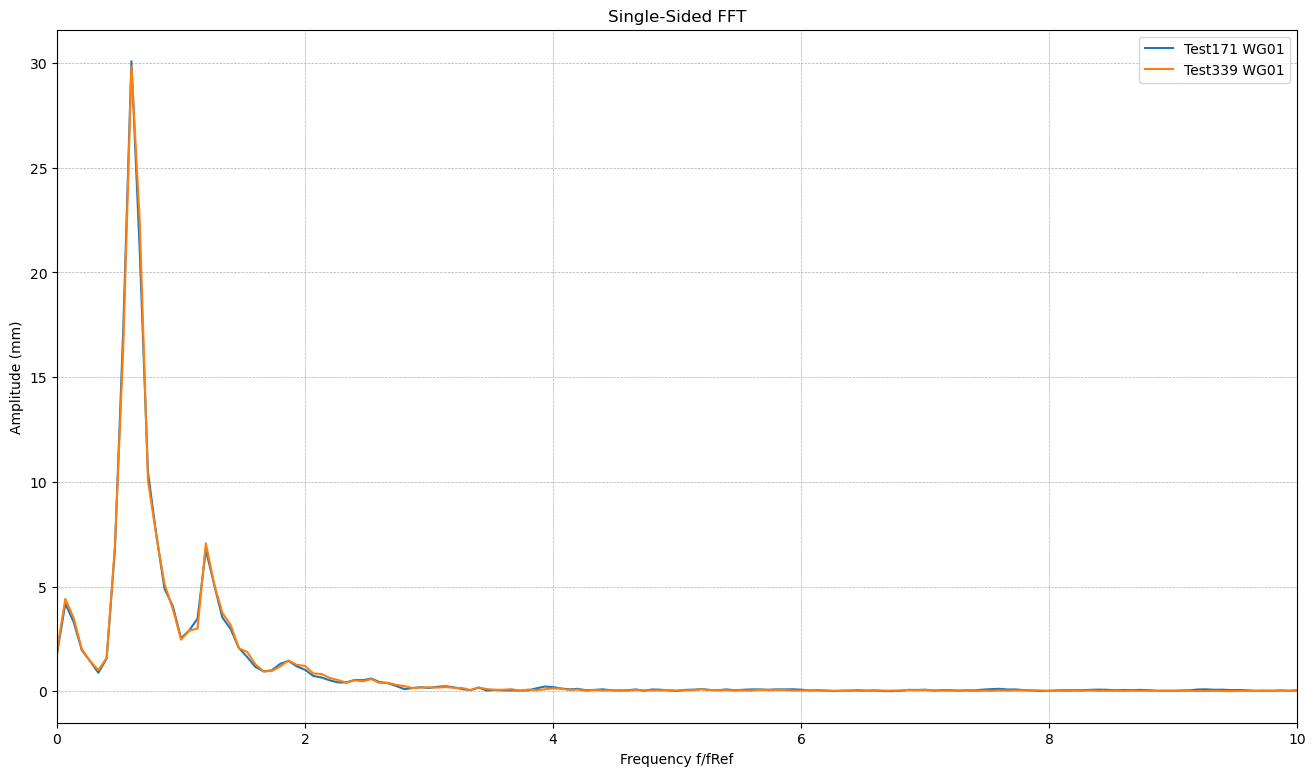

In [698]:
tmin = xmin #50
tmax = xmax #80

ds1_cut = ds1.sel(Time=slice(tmin, tmax))
ds2_cut = ds2.sel(Time=slice(tmin, tmax))

# Plot spectrum
fig, ax = plt.subplots(figsize=(16,9))
xlim = (0, 10)
getSpec(ds1_cut['WG01'], fSampling1, ax, xlim, f"{testName1} WG01")
# getSpec(ds1_cut['WG05'], fSampling1, ax, xlim, f"{testName1} WG05")
# getSpec(ds1_cut['WG07'], fSampling1, ax, xlim, f"{testName1} WG07")
getSpec(ds2_cut['WG01'], fSampling2, ax, xlim, f"{testName2} WG01")

pass